In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Text Vectorizer Model", "Optimal K-value", "Scoring Metric", "Accuracy", "TPR", "TNR", "FPR", "FNR"]

In [3]:
%%time
con = sqlite3.connect('database.sqlite')
raw_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
raw_data = raw_data.sample(150000, random_state=42)
raw_data = raw_data.sort_values('Time')
print(raw_data.shape)

(150000, 10)
Wall time: 4.64 s


In [3]:
def preprocess(data):
    '''
    Preprocess I/P data :-
    1. Update Score with 0 (-ve Review) and 1 (+ve Review).
    2. Add another feature with Review length and use Log to reduce scale.
    3. Select unique rows based on - UserId, ProfileName, Time and Text.
    4. Remove rows which have helpfulness denominator greater than helpfulness numerator.
    5. Remove html tags from Reviews.
    6. Remove punctuations and special characters.
    7. Performing Stemming using Snowball Stemmer.
    8. Extract Adjectives, Nouns, Verbs, Adverbs from 'Summary' column and add it to the 'CleanedText' column.
    '''
    # Update 'Score' with 0 -> Negative Review and 1 -> Positive Review
    data['Score'] = data['Score'].map(lambda x: 0 if x<3 else 1)
    data['TextLength'] = data['Text'].apply(lambda x: math.log(len(x.split())))

    data = data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'})
    data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]

    stops = set(stopwords.words('english')) - set(['not'])
    snow = SnowballStemmer('english')

    # Function to clean the word of any html-tags
    def cleanhtml(sentence):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', sentence)
        return cleantext

    # Function to clean the word of any punctuation or special characters
    def cleanpunc(sentence):
        cleaned = re.sub(r'[?|!|\'|"|:|#]',r' ',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        return  cleaned

    filtered_reviews = []
    s = ''

    for review in data['Text'].values:
        filtered_sent = []
        review = cleanhtml(review)
        review = cleanpunc(review)
        for word in review.split():
            if word.isalpha() and len(word) > 2:
                if word.lower() not in stops:
                    s = snow.stem(word.lower())
                    filtered_sent.append(s)
        filtered_reviews.append(' '.join(filtered_sent))
        
    tags = []
    for review in data['Summary'].values:
        review = cleanhtml(review)
        review = cleanpunc(review)
        adjs = [x[0] for x in nltk.pos_tag(word_tokenize(review)) if x[1].startswith('JJ') \
                or x[1].startswith('RB') or x[1].startswith('VB') or x[1] == 'NNP']
        if len(adjs) > 0:
            adjs = ' '.join([snow.stem(word.lower()) if len(word) > 2 and word.lower() not in stops else '' for word in adjs])
        tags.append(adjs)
    
    print('Total Data-points :-',len(filtered_reviews))
    data['CleanedText'] = [str(filtered_reviews[i]) + ' ' + str(tags[i]) for i in range(len(tags))]
    return data

In [4]:
def plot_scores(nb_optimal):
    _, = plt.plot(list(nb_optimal.cv_results_['param_alpha']), \
                      list(nb_optimal.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(nb_optimal.cv_results_['param_alpha']), \
                      list(nb_optimal.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(nb_optimal.best_params_['alpha'], nb_optimal.best_score_, 'bo', \
                     label=f"Optimal Value (a={nb_optimal.best_params_['alpha']}, Score={round(nb_optimal.best_score_,2)})")

    plt.xscale('log')
    plt.xlabel('Laplace Smoothing Parameter (Alpha)')
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [5]:
def normalize_data(train, train_vectors, test, test_vectors):
    sc = Normalizer()
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_train = sc.fit_transform(X_train)
    print(X_train.shape, train_vectors.shape)
    X_train = sparse.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_test = sc.transform(X_test)
    X_test = sparse.hstack((X_test, test_vectors))
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [6]:
def run_NB(train, train_vectors, test, test_vectors, metric='precision_macro'):
    '''
    Perform Multinomial NB modelling on the I/P Train and Test data.
    1. Remove not required Columns, Normalize data and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal 'alpha' - Laplace Smoothing parameter.
    3. Use the Optimal 'alpha' based model on the Training data and evaluate the Test data.
    4. Calculate Accuracy of Model and TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns, Normalize data and concatenate data with text vectors
    X_train, y_train, X_test, y_test = normalize_data(train, train_vectors, test, test_vectors)
    del train, train_vectors, test, test_vectors

    params = {'alpha': (0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 12.0, 15.0, 20.0, 22.0)}
    nb = MultinomialNB()
    nb_optimal = GridSearchCV(nb, param_grid=params, cv=3, scoring=metric, verbose=1, refit=True)
    nb_optimal.fit(X_train, y_train)
    
    # Plot Train vs Test Scores and the Optimal Parameter
    plot_scores(nb_optimal)

    print(f'coef_ shape: {nb_optimal.best_estimator_.coef_.shape}')
    del X_train, y_train
    pred = []
    
    for i in range(0, X_test.shape[0], 2000):
        test_batch = X_test.todok()[i:i+2000]
        pred.extend(nb_optimal.predict(test_batch))

    acc = accuracy_score(y_test, pred) * 100
    print(f'\nThe Accuracy of the Multinomial NB classifier for alpha = {nb_optimal.best_params_["alpha"]} is {acc} %')
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    return [nb_optimal.best_params_["alpha"], metric, round(acc,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), nb_optimal.best_estimator_.coef_[0]]

In [7]:
def get_data(data_points):
    '''
    Perform pre-processing on raw data and extract required datapoints :: 70-30 Split.
    '''
    split = int(data_points * 0.70)
    data = preprocess(raw_data)
    train = data[:split]
    test = data[split:data_points]

    print(train['Score'].value_counts())
    print(test['Score'].value_counts())
    return train, test

In [8]:
def save_model_info(model, info):
    '''
    Save Model info in a csv file for future use.
    '''
    with open("Model_Scores.csv","a") as f:
        out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
        out.writerow([model] + info)

In [9]:
def get_best_metric(d_train, vec_train, d_test, vec_test, vectorizer="BOW"):
    pt = PrettyTable()
    pt.field_names = ["Text Vectorizer Model", "NB Model", "Scoring Metric", "Score", "TPR", "TNR", "FPR", "FNR"]
    metrics = ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', \
              'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro',\
              'f1_weighted', 'homogeneity_score', 'mutual_info_score',\
              'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error',\
              'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro',\
              'precision_micro', 'precision_weighted', 'r2', 'recall', 'recall_macro',\
              'recall_micro', 'recall_weighted', 'roc_auc', 'v_measure_score']

    scores = []
    for i in metrics:
        info = run_NB(d_train, vec_train, d_test, vec_test, metric=i)
        pt.add_row([vectorizer] + info)
    return pt

In [9]:
%%time
data_train, data_test = get_data(20000)

Total Data-points :- 24655
0    12473
1     1527
Name: Score, dtype: int64
0    5250
1     750
Name: Score, dtype: int64
Wall time: 40.2 s


In [10]:
%%time
cv_model = CountVectorizer(max_features=7000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

pt = get_best_metric(data_train, bow_counts_train.toarray(), data_test, bow_counts_test.toarray())
print(pt.get_string(sortby='TNR', reversesort=True))

(14000, 3332) (6000, 3332)
+-----------------------+----------+------------------------------+-------+-------+-------+-------+------+
| Text Vectorizer Model | NB Model |        Scoring Metric        | Score |  TPR  |  TNR  |  FPR  | FNR  |
+-----------------------+----------+------------------------------+-------+-------+-------+-------+------+
|          BOW          |   10.0   |            recall            |  89.8 | 90.76 | 69.93 | 30.07 | 9.24 |
|          BOW          |   10.0   |       precision_macro        |  89.8 | 90.76 | 69.93 | 30.07 | 9.24 |
|          BOW          |   10.0   |              f1              |  89.8 | 90.76 | 69.93 | 30.07 | 9.24 |
|          BOW          |   10.0   |      explained_variance      |  89.8 | 90.76 | 69.93 | 30.07 | 9.24 |
|          BOW          |  0.0001  |       recall_weighted        | 89.77 | 93.25 | 58.88 | 41.12 | 6.75 |
|          BOW          |  0.0001  |         recall_micro         | 89.77 | 93.25 | 58.88 | 41.12 | 6.75 |
|         

In [10]:
%%time
data_train, data_test = get_data(80000)
del raw_data

Total Data-points :- 124264
1    48338
0     7662
Name: Score, dtype: int64
1    19901
0     4099
Name: Score, dtype: int64
Wall time: 3min 22s


In [7]:
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

# BOW model with 80k datapoints

(56000, 9397) (24000, 9397)
(56000, 4) (56000, 9397)
X_Train: (56000, 9401)
y_Train: (56000,)
X_Test: (24000, 9401)
y_Test: (24000,)
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    2.0s finished


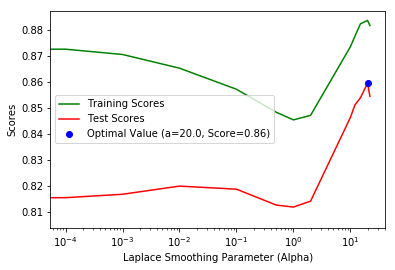

coef_ shape: (1, 9401)

The Accuracy of the Multinomial NB classifier for alpha = 20.0 is 87.10833333333333 %

Confusion Matrix :-
[[ 1186  2913]
 [  181 19720]]

TPR: 87.1294128043123 %
TNR: 86.75932699341624 %
FPR: 13.240673006583762 %
FNR: 12.870587195687714 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.87      0.29      0.43      4099
          1       0.87      0.99      0.93     19901

avg / total       0.87      0.87      0.84     24000

Wall time: 16.9 s


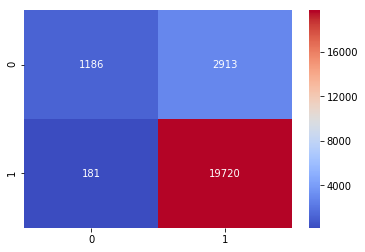

In [8]:
%%time
cv_model = CountVectorizer(max_features=15000, min_df=5)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

info = run_NB(data_train, bow_counts_train, data_test, bow_counts_test, metric='precision_macro')

In [9]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Lowest_Coeff", "Worst_Features", "Highest Coeff", "Best_Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+--------------+------------------------+---------------+---------------+
| Lowest_Coeff |     Worst_Features     | Highest Coeff | Best_Features |
+--------------+------------------------+---------------+---------------+
|   -11.555    |          bleh          |     -3.764    |      Time     |
|   -11.555    |        dislodg         |     -4.476    |      not      |
|   -11.555    |       misfortun        |     -4.487    |     great     |
|   -11.555    |        nastiest        |     -4.561    |      like     |
|   -11.555    |       toxicolog        |     -4.565    |      good     |
|   -11.555    |        unremark        |     -4.624    |      tast     |
|   -11.555    |  HelpfulnessNumerator  |     -4.638    |      love     |
|   -11.555    | HelpfulnessDenominator |     -4.771    |     flavor    |
|   -11.555    |       TextLength       |     -4.874    |      tea      |
|   -11.506    |         atroci         |     -4.911    |      use      |
|   -11.506    |        autolyz       

In [10]:
pt.add_row(["BOW"] + info[:-1])
print(pt)

+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
| Text Vectorizer Model | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|          BOW          |       20.0      | precision_macro |  87.11   | 87.13 | 86.76 | 13.24 | 12.87 |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+


In [11]:
del cv_model, bow_counts_train, bow_counts_test

# TFIDF model with 80k datapoints

(56000, 9397) (24000, 9397)
(56000, 4) (56000, 9397)
X_Train: (56000, 9401)
y_Train: (56000,)
X_Test: (24000, 9401)
y_Test: (24000,)
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    2.1s finished


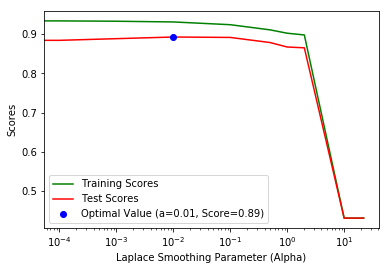

coef_ shape: (1, 9401)

The Accuracy of the Multinomial NB classifier for alpha = 0.01 is 87.10833333333333 %

Confusion Matrix :-
[[ 1099  3000]
 [   94 19807]]

TPR: 86.84614372780287 %
TNR: 92.12070410729254 %
FPR: 7.879295892707461 %
FNR: 13.153856272197132 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.92      0.27      0.42      4099
          1       0.87      1.00      0.93     19901

avg / total       0.88      0.87      0.84     24000

Wall time: 16.9 s


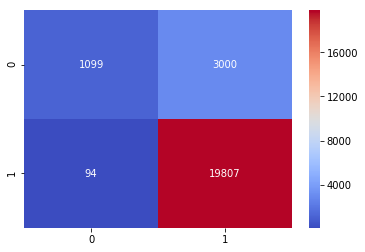

In [12]:
%%time
tfidf_model = TfidfVectorizer(max_features=15000, min_df=5)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

info = run_NB(data_train, tfidf_train, data_test, tfidf_test, metric='precision_macro')

In [13]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Lowest_Coeff", "Worst_Features", "Highest Coeff", "Best_Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                    + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+--------------+------------------------+---------------+---------------+
| Lowest_Coeff |     Worst_Features     | Highest Coeff | Best_Features |
+--------------+------------------------+---------------+---------------+
|    -17.12    |          bleh          |     -1.729    |      Time     |
|    -17.12    |        dislodg         |     -4.985    |     great     |
|    -17.12    |       misfortun        |     -5.118    |      love     |
|    -17.12    |        nastiest        |     -5.147    |      good     |
|    -17.12    |       toxicolog        |     -5.252    |      tea      |
|    -17.12    |        unremark        |     -5.309    |      tast     |
|    -17.11    |  HelpfulnessNumerator  |     -5.333    |      like     |
|   -17.109    | HelpfulnessDenominator |     -5.356    |      not      |
|   -17.105    |       TextLength       |     -5.39     |     flavor    |
|    -15.0     |       professor        |     -5.401    |     coffe     |
|   -14.964    |         fraud        

In [14]:
pt.add_row(["TFIDF"] + info[:-1])
print(pt)

+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
| Text Vectorizer Model | Optimal K-value |  Scoring Metric | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+
|          BOW          |       20.0      | precision_macro |  87.11   | 87.13 | 86.76 | 13.24 | 12.87 |
|         TFIDF         |       0.01      | precision_macro |  87.11   | 86.85 | 92.12 |  7.88 | 13.15 |
+-----------------------+-----------------+-----------------+----------+-------+-------+-------+-------+


In [15]:
del tfidf_model, tfidf_train, tfidf_test

# Conclusions :-
-  For this Classification problem, Multinomial NB has been selected as the dataset contains discrete data - frequency of words through the use of Text Vectors (BOW and TFIDF).
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, both 'recall' and 'precision_macro' have shown to provide high True Negative Rate (TNR) or low False Positive Rate (FPR). Here, a subset of data has been taken and various Scoring Metrics have been applied to determine the best one. 'precision_macro' metric has been used here to evaluate the models. 
-  From the Performances obtained on the two Vectorizer models, it has been observed that TFIDF Vectorizer is giving the best performance - high TPR with a higher TNR.
-  The Model performance might improve if the unbalancedness of the dataset can be treated with Oversampling - repeating Minority class or creating Synthetic datapoints using SMOTE.
-  Reducing the 'n_components' in the Vectorizer models has proved to increase the True Negative Rate.
-  The best features in both the Text-Vectorizer models shows similar results.